#Background on HTTPS Transition

Best Summed up by an email from Brandon:
    
1) The transition involves enabling a redirect - therefore even if
nothing else changed about user behavior, there would be some spike in
raw HTTP request rate, as all connections to HTTP result in a second
request after redirection to HTTPS.  The response to the initial HTTP
request would be with response HTTP status code 301 or 302, so
filtering stats on those exact codes may help see through this.  This
does not cause a strict doubling of request rate: it would double
external HTTP requests, but a large majority of raw hits would be
internal (resources loaded within a page, user clicking links on
existing open page, etc), all of which would be protocol-relative to
an earlier received redirect and not attempt HTTP initially.

2) Some percentage of users were already using HTTPS (due to being
logged in and/or using the HTTPS Everywhere extension, or manual
preference).  Stats from earlier this year indicated that, across all
wikis, this was on the order of ~11%.

3) As the timeline moves forward from the change point, increasingly
search engines like Google begin to update their links to us to be
HTTPS directly, which cuts down on the HTTP-redirect traffic.

4) At a later time (typically hours, up to a full day) after each
switch, we've enabled HSTS.  HSTS further reduces redirect traffic on
the browser side.  Once a given supporting browser (mostly modern
ones) sees our HSTS header, even if they try to follow e.g. a Google
link which specifies HTTP, their browser knows internally that it must
make the request to us over HTTPS.

5) Some time at or after the point of HSTS, we also switch the setting
for internal rel=canonical URLs within the pages - this provides
stronger hints to use HTTPS for search engine links than the initial
redirect did.  However, this change is spread out over a long period,
as it's part of the cached content of our pages and we're not
invalidating our content caches to force this to update from the
external point of view.

6) Specific to the English Wikipedia transition: by a stroke of
horrible coincidence, at nearly the same moment we began the technical
process for the enwiki transition, there was a serious incident on the
global routing backbones of the Internet, which caused all kinds of
latency, packet loss, and site unavailability for many Internet users
and sites.  This is completely orthogonal to anything Wikimedia does
and is out of our control.  We were spared the worst of the impact
(most of our users were relatively-unaffected), but there were
definite movements in our stats that were related to this.  I've noted
the approximate timeline of this incident in the list of our
transition timelines below, but here's some general info links on it:

http://www.theregister.co.uk/2015/06/12/level_3_down_after_routing_through_malaysia_like_idiots/
https://twitter.com/bgpmon/status/609322034011582464/photo/1
https://www.cloudflarestatus.com/incidents/bzknm1t91kjq

Languages:
The Chinese languages are Chinese (zh) and Uyghur (ug)
The HTTPS-Beta languages are Catalan (ca), Hebrew (he), Greek (el),
Italian (it).

Timeline:
* 2015-06-09 21:23 UTC: transitioned Chinese languages, all projects
* 2015-06-11 14:00 UTC: transitioned HTTPS-Beta language Wikipedias
* 2015-06-11 14:30 UTC: transitioned HTTPS-Beta language Mobile Wikipedias
* 2015-06-12 08:43 UTC: Routing Incident: First evidence (others noticing, not us)
* 2015-06-12 09:00 UTC: Routing Incident: Level3 fallout in full effect,many notice
* 2015-06-12 09:00 UTC: Start transition of English Wikipedia, including Mobile -- During this 40 minute window for English, we first redirected 10% of clients, then 50%, then 100%
* 2015-06-12 09:40 UTC: End transition of English Wikipedia, including Mobile
* 2015-06-12 10:40 UTC: Routing Incident: Largely resolved, some smaller trailing effects
* 2015-06-12 13:00 UTC: Public blog announcement
* 2015-06-12 13:30 UTC: transitioned All other projects (e.g.
wikiversity, wikibooks, etc) for English + Beta languages

#Background on Data Collection

The data for the following analysis is collected from the webrequest logs in Hive. The data includes only pageviews broken down by the uri_host, , access method and agent type. We are in the process breaking down the data further by protocol (http/https).

#Code

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
% matplotlib inline

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 27 days


In [2]:
#Time points
china_start = datetime.strptime('2015-06-09 21:23', "%Y-%m-%d %H:%M") # transitioned Chinese languages, all projects        
beta_start = datetime.strptime('2015-06-11 14:00', "%Y-%m-%d %H:%M") # transitioned HTTPS-Beta language Wikipedias
mobile_beta_start = datetime.strptime('2015-06-11 14:30', "%Y-%m-%d %H:%M") # transitioned HTTPS-Beta language Mobile Wikipedias
incident_start = datetime.strptime('2015-06-12 08:43', "%Y-%m-%d %H:%M") # Routing Incident: First evidence (others noticing, not us)
incident_peak = datetime.strptime('2015-06-12 09:00', "%Y-%m-%d %H:%M") # Routing Incident: Level3 fallout in full effect, many notice
english_start = datetime.strptime('2015-06-12 09:00', "%Y-%m-%d %H:%M") # Start transition of English Wikipedia, including Mobile
english_end = datetime.strptime('2015-06-12 09:40', "%Y-%m-%d %H:%M") # End transition of English Wikipedia, including Mobile
incident_end = datetime.strptime('2015-06-12 10:40', "%Y-%m-%d %H:%M") # Routing Incident: Largely resolved, some smaller trailing effects

In [50]:
# plotting utilities
def plot_project(df, uri_host, time):
    d = df[df['uri_host'] == uri_host]
    d = d.groupby('date').sum()
    plt.figure()
    if time:
        plt.axvline(time, color='r')
    d['n'].plot()
    plt.title(uri_host)
    
def plot_disaggregation(df, uri_host, country, access_method, agent_type, time = None):
    d = df[df['uri_host'] == uri_host]
    if country:
        d = d[d['country'] == country]
    if access_method:
        d = d[d['access_method'] == access_method]
    if agent_type:
        d = d[d['agent_type'] == agent_type]
    d.index = d['date']
    plt.figure()
    d['n'].plot()
    if time:
        plt.axvline(time, color='r')
        
    plt.title('%s traffic from %s to %s via %s device ' % (agent_type, country,uri_host,access_method ))

In [51]:
# Load the data
df = pd.read_csv('http_transition.tsv', sep = '\t')
def make_date(d):
    return datetime(year=d['year'], month=d['month'], day=d['day'], hour =d['hour'])
df['date'] = df.apply(make_date, axis=1)
df['n'] = df['n'] * 64

#Analysis

We will be examining pageviews over time broken down by various dimensions. The red line will indicate the time of transition to https. The request is for a "traffic analysis". Im the abscence of further information, I am assuming this means that we want to see how pageviews evolve after the transitions to https.

## Host Level Analysis

First lets look at pageviews broken down by the host. We will examine first the chinese language wikipedia, then the beta languages, then english wikipedia.

###China

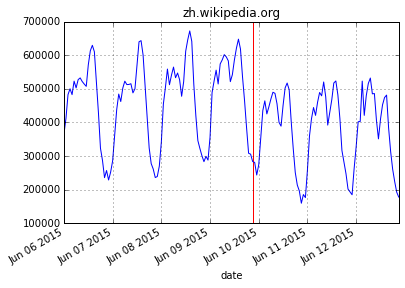

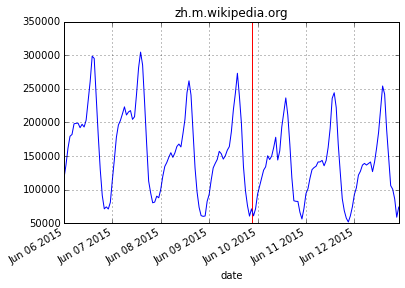

In [52]:
plot_project(df, 'zh.wikipedia.org', china_start)
plot_project(df, 'zh.m.wikipedia.org', china_start)

It appears as if dektop traffic to Chinese Wikipedia was compromized. Lets take a closer look. First, what are the top countries from where the traffic is coming.

In [66]:
d = df[df['uri_host'] == 'zh.wikipedia.org'][['country', 'n']].groupby('country').sum().sort('n', ascending = False)[:5]
d

,n
country,
United States,27856000
Taiwan,24745024
Hong Kong,8125888
Malaysia,1157120
China,1099968


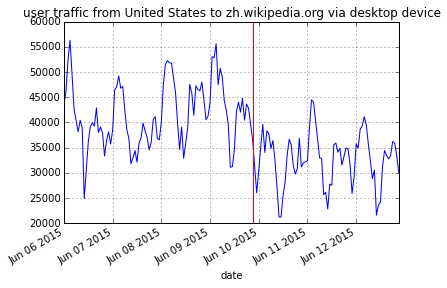

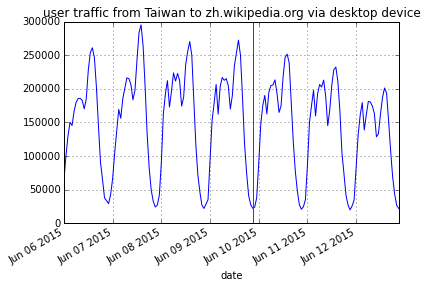

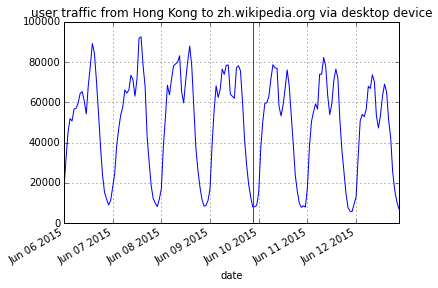

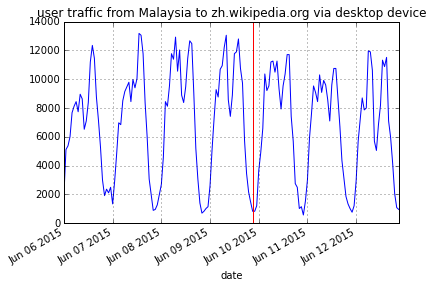

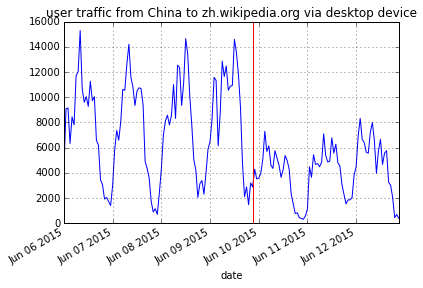

In [68]:
uri_host = 'zh.wikipedia.org'
access_method = 'desktop'
agent_type = 'user'
for country in d.index: 
    plot_disaggregation(df, uri_host, country, access_method, agent_type, time = china_start)

Pageviews for zhwiki from desktop devices in China took a hit, but not large enough to account for the magnitude of the drop. Lets check the bots:

In [57]:
d = df[df['agent_type'] == 'spider']
d[d['uri_host'] == 'zh.wikipedia.org'][['country', 'n']].groupby('country').sum().sort('n', ascending = False)[:5]

,n
country,
United States,21625088
Czech Republic,599744
France,188352
Germany,161792
China,67264


Ok, most bot traffic comes from the US.

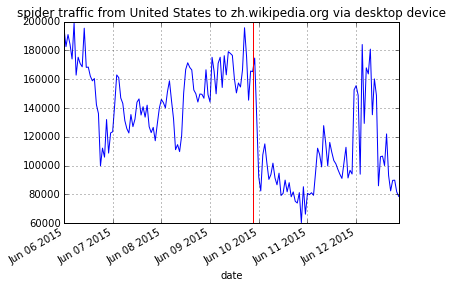

In [59]:
uri_host = 'zh.wikipedia.org'
country = 'United States'
access_method = 'desktop'
agent_type = 'spider'
plot_disaggregation(df, uri_host, country, access_method, agent_type, time = china_start)

And there we go, spider traffic crashed at the point of transition.

### Beta Countries

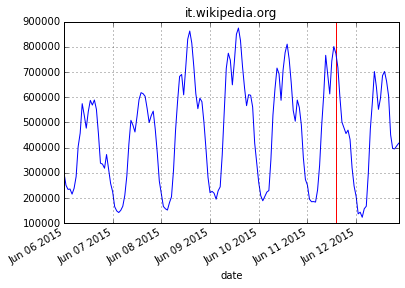

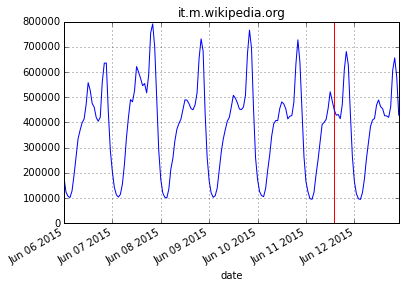

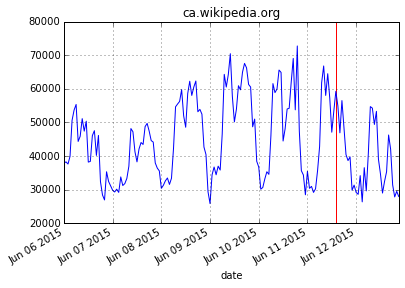

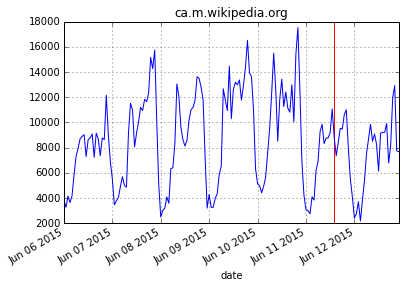

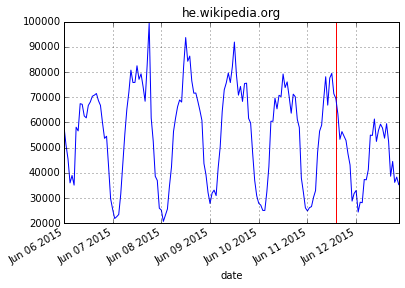

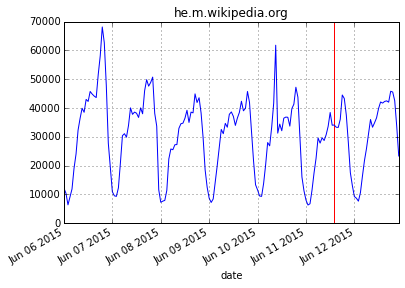

In [6]:
plot_project(df, 'it.wikipedia.org', beta_start)
plot_project(df, 'it.m.wikipedia.org', beta_start)
plot_project(df, 'ca.wikipedia.org', beta_start)
plot_project(df, 'ca.m.wikipedia.org', beta_start)
plot_project(df, 'he.wikipedia.org', beta_start)
plot_project(df, 'he.m.wikipedia.org', beta_start)

Transitions for these countries appear to have gone smoothly

### English Wikipedia

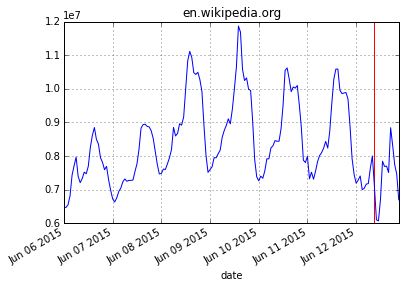

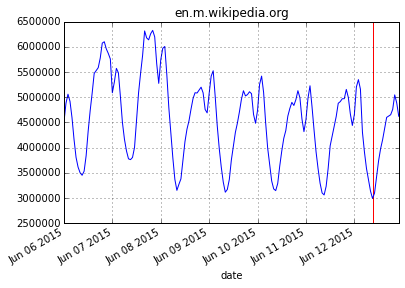

In [62]:
plot_project(df, 'en.wikipedia.org', english_start)
plot_project(df, 'en.m.wikipedia.org', english_start)

We do not yet have enough data to tell.

##Enwiki from China 

###Mobile

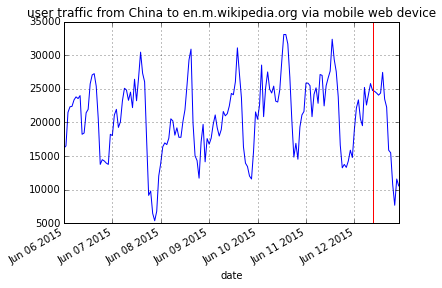

In [63]:
uri_host = 'en.m.wikipedia.org'
country = 'China'
access_method = 'mobile web'
agent_type = 'user'
plot_disaggregation(df, uri_host, country, access_method, agent_type, time = english_start)

###Dektop

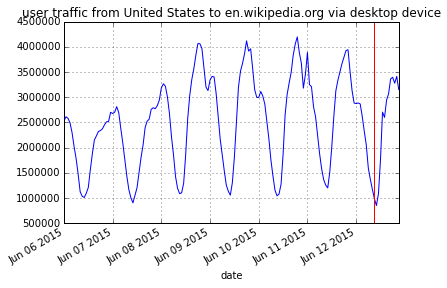

In [64]:
uri_host = 'en.wikipedia.org'
country = 'United States'
access_method = 'desktop'
agent_type = 'user'
plot_disaggregation(df, uri_host, country, access_method, agent_type, time = english_start)

This looks ok, but again lets get a bit more data.